In [2]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA

C:\Users\goert\AppData\Local\Temp\ipykernel_14628\2780907528.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:

MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data"

QUALITY_THRESHOLD = 64
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024
NUM_FOLDS = 10

**Choice options of metrics are as follows:**
- w_eda
- cvx_phasic
- cvx_tonic

In [5]:
METRIC = "w_eda"

**MODEL CONFIGURATION**

- adjust if necessary. This defines the model's performance

In [6]:
# dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

# IMPORTANT : UNCOMMIT THE FOLLOWING LINE WHEN CONVERTING TO PYTHON FILE. GITHUB ACTIONS ONLY ACCEPT RELATIVE PATHS!
dataset = pd.read_csv("data/merged_data.csv")


In [7]:
import cvxEDA.src.cvxEDA

def calculate_eda_levels(y):
    fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
    Fs = fs_dict['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.src.cvxEDA.cvxEDA(yn, 1. / Fs)
    return r, t, yn


In [8]:
import matplotlib.pyplot as plt

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Initialize the new DataFrame
new_dataframe_eda = pd.DataFrame(columns=["cvx_phasic", "cvx_tonic"])

# Iterate through each unique id
for unique_id in unique_ids:
    # Filter data for each id
    subset_data = dataset[dataset['ID'] == unique_id]
    
    # Calculate EDA levels
    phasic, tonic, yn = calculate_eda_levels(subset_data['w_eda'].values)
    
    # Create a temporary DataFrame to hold the new data
    temp_df = pd.DataFrame({
        "cvx_phasic": phasic, 
        "cvx_tonic": tonic
    })

    new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)

    # # Plotting
    # plt.plot(tonic, label='Tonic')
    # plt.plot(phasic, label='Phasic')
    # plt.plot(subset_data['w_eda'].values, label='EDA')
    
    # plt.xlabel('Time')
    # plt.ylabel('EDA Levels')
    # plt.title(f'Phasic and Tonic EDA for ID: {unique_id}')
    # plt.legend()
    # plt.show()


     pcost       dcost       gap    pres   dres
 0: -1.2092e+04 -1.2037e+04  5e+04  2e+02  2e-01
 1: -1.2089e+04 -2.0310e+04  1e+04  4e+01  5e-02
 2: -1.2096e+04 -1.5177e+04  3e+03  1e+01  1e-02
 3: -1.2097e+04 -1.3431e+04  1e+03  4e+00  4e-03
 4: -1.2096e+04 -1.2680e+04  6e+02  1e+00  2e-03
 5: -1.2091e+04 -1.2408e+04  3e+02  5e-01  6e-04
 6: -1.2091e+04 -1.2262e+04  2e+02  2e-01  3e-04
 7: -1.2109e+04 -1.2156e+04  5e+01  3e-02  4e-05
 8: -1.2129e+04 -1.2144e+04  1e+01  9e-03  1e-05
 9: -1.2136e+04 -1.2142e+04  6e+00  3e-03  3e-06
10: -1.2139e+04 -1.2142e+04  3e+00  8e-04  1e-06
11: -1.2140e+04 -1.2141e+04  1e+00  2e-04  2e-07
12: -1.2141e+04 -1.2141e+04  4e-01  4e-05  5e-08
13: -1.2141e+04 -1.2141e+04  1e-01  8e-06  1e-08
14: -1.2141e+04 -1.2141e+04  3e-02  5e-07  6e-10
15: -1.2141e+04 -1.2141e+04  9e-03  5e-08  7e-11
16: -1.2141e+04 -1.2141e+04  3e-03  1e-08  1e-11
17: -1.2141e+04 -1.2141e+04  7e-04  2e-09  2e-12
18: -1.2141e+04 -1.2141e+04  1e-04  2e-10  2e-13
19: -1.2141e+04 -1.21

C:\Users\goert\AppData\Local\Temp\ipykernel_14628\594686967.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_dataframe_eda = pd.concat([new_dataframe_eda, temp_df], ignore_index=True)


 1: -1.2950e+04 -1.7515e+04  5e+03  2e+01  2e-02
 2: -1.2952e+04 -1.3636e+04  7e+02  3e+00  2e-03
 3: -1.2950e+04 -1.3146e+04  2e+02  7e-01  4e-04
 4: -1.2956e+04 -1.3006e+04  5e+01  1e-01  7e-05
 5: -1.2973e+04 -1.2984e+04  1e+01  1e-02  8e-06
 6: -1.2978e+04 -1.2983e+04  5e+00  3e-03  2e-06
 7: -1.2981e+04 -1.2983e+04  2e+00  1e-03  7e-07
 8: -1.2982e+04 -1.2983e+04  8e-01  3e-04  2e-07
 9: -1.2983e+04 -1.2983e+04  3e-01  7e-05  5e-08
10: -1.2983e+04 -1.2983e+04  1e-01  2e-05  1e-08
11: -1.2983e+04 -1.2983e+04  4e-02  4e-06  3e-09
12: -1.2983e+04 -1.2983e+04  1e-02  7e-07  5e-10
13: -1.2983e+04 -1.2983e+04  3e-03  1e-07  9e-11
14: -1.2983e+04 -1.2983e+04  9e-04  2e-08  1e-11
15: -1.2983e+04 -1.2983e+04  3e-04  3e-09  2e-12
16: -1.2983e+04 -1.2983e+04  6e-05  2e-10  2e-13
17: -1.2983e+04 -1.2983e+04  1e-05  2e-11  2e-14
18: -1.2983e+04 -1.2983e+04  2e-06  2e-12  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2831e+04 -1.2794e+04  4e+04  2e+02  3e-

In [9]:
dataset = pd.concat([dataset, new_dataframe_eda], axis=1)

In [10]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(merged_df, max_length=32):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None
    phasic_eda_sequence = []
    tonic_eda_sequence = []

    for index, row in merged_df.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence,
                    'cvx_phasic': phasic_eda_sequence,
                    'cvx_tonic': tonic_eda_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
            phasic_eda_sequence = [row['cvx_phasic']]
            tonic_eda_sequence = [row['cvx_tonic']]
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])
            phasic_eda_sequence.append(row['cvx_phasic'])
            tonic_eda_sequence.append(row['cvx_tonic'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence,
                'cvx_phasic': phasic_eda_sequence,
                'cvx_tonic': tonic_eda_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None
            phasic_eda_sequence = []
            tonic_eda_sequence = []

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence,
            'cvx_phasic': phasic_eda_sequence,
            'cvx_tonic': tonic_eda_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)


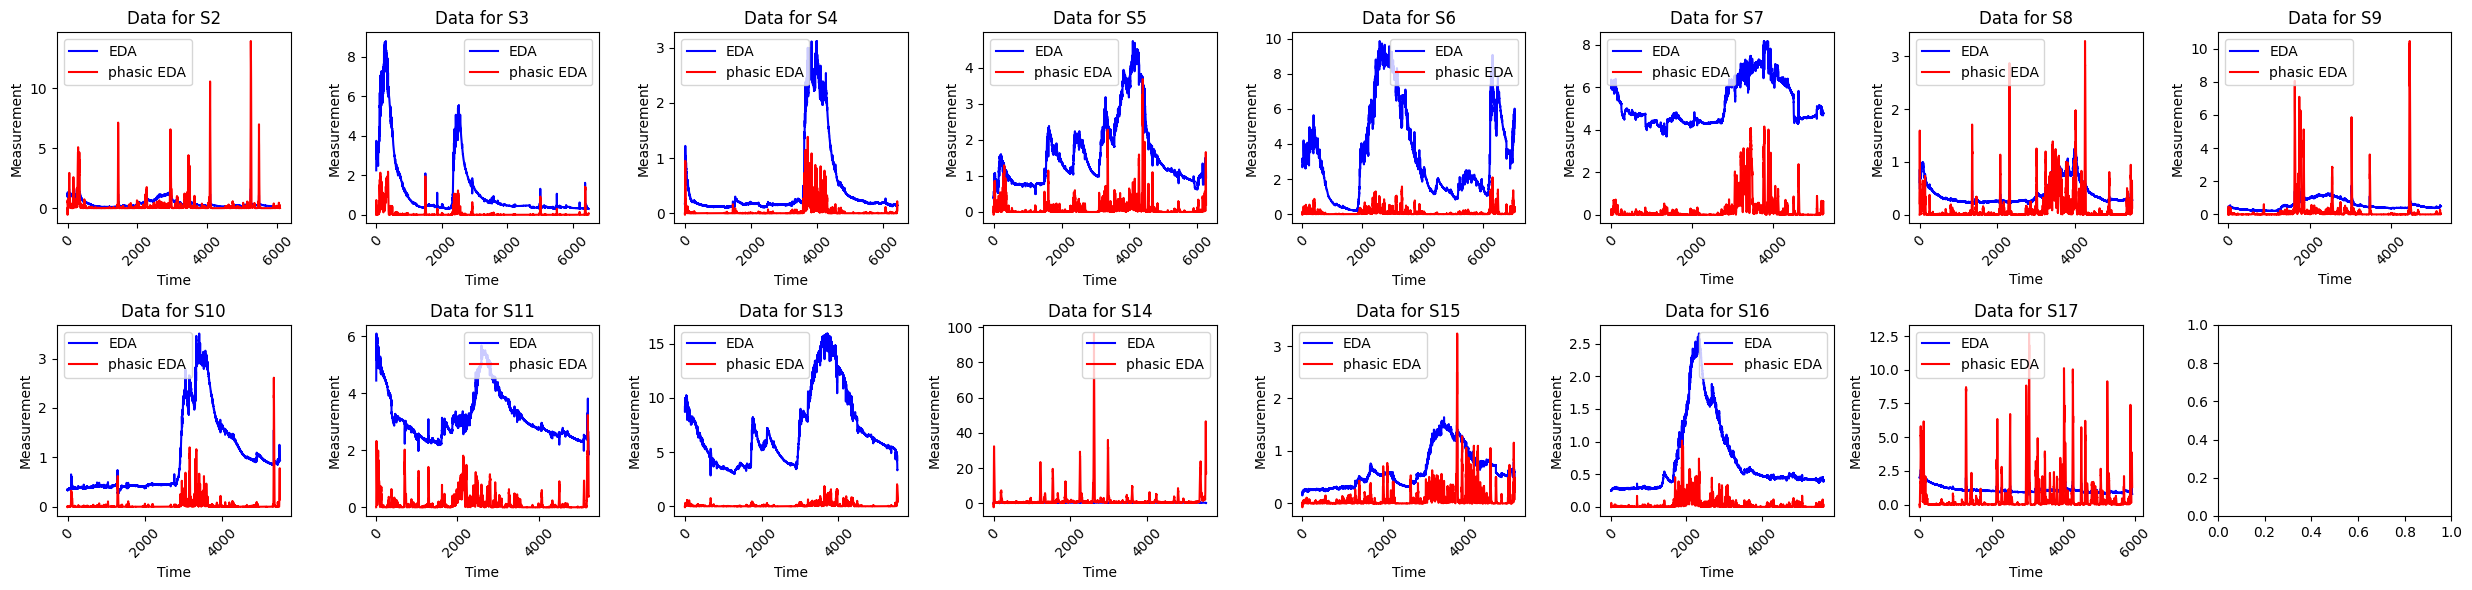

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        sns.lineplot(x='Time', y='cvx_phasic', data=subset_data, ax=axes[i], color='red', label='phasic EDA')
        # sns.lineplot(x='Time', y='cvx_tonic', data=subset_data, ax=axes[i], color='yellow', label='tonic EDA')                  
        # sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
sequences_df

,ID,w_eda,w_temp,downsampled_label,Time,cvx_phasic,cvx_tonic
0,S2,"[1.138257, 1.125444, 1.011405, 1.033188, 0.935...","[35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....",0.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, -0.29028704534925953, -0.4463023106...","[2.235824015415713, 2.2410226078538633, 2.2434..."
1,S2,"[1.116375, 1.109969, 1.104843, 1.099718, 1.094...","[35.45, 35.45, 35.45, 35.45, 35.41, 35.41, 35....",0.0,"[8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 1...","[0.5369178880335287, 0.5403534726202395, 0.541...","[1.6619116206256164, 1.6417932937848856, 1.622..."
2,S2,"[1.249634, 1.261166, 1.267572, 1.270135, 1.275...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0.0,"[16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, ...","[0.7534719745225507, 0.7671649763600733, 0.757...","[1.8486647634733069, 1.874705656805469, 1.9012..."
3,S2,"[1.299606, 1.300887, 1.300887, 1.298324, 1.299...","[35.45, 35.45, 35.45, 35.45, 35.43, 35.43, 35....",0.0,"[24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, ...","[0.1489031808309924, 0.13299542956110286, 0.11...","[2.610592808693715, 2.625337313560814, 2.63934..."
4,S2,"[1.289355, 1.289355, 1.288074, 1.288074, 1.286...","[35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....",0.0,"[32.0, 32.25, 32.5, 32.75, 33.0, 33.25, 33.5, ...","[0.05310540340836996, 0.06695184337039853, 0.0...","[2.6721126459941202, 2.6586801486398914, 2.644..."
...,...,...,...,...,...,...,...
10859,S17,"[0.922787, 0.939419, 0.945816, 0.945816, 0.944...","[31.93, 31.91, 31.91, 31.91, 31.91, 31.93, 31....",0.0,"[5880.0, 5880.25, 5880.5, 5880.75, 5881.0, 588...","[3.167426942619043, 3.1266598265997567, 3.0487...","[-3.8061206452028054, -3.6971745332197568, -3...."
10860,S17,"[0.931742, 0.929184, 0.933022, 0.929184, 0.931...","[31.95, 31.99, 31.99, 31.99, 31.99, 31.99, 31....",0.0,"[5888.0, 5888.25, 5888.5, 5888.75, 5889.0, 588...","[0.43613866472046775, 0.3890677608522584, 0.34...","[-1.0450328296645508, -0.9987983684322405, -0...."
10861,S17,"[0.922787, 0.908713, 0.917669, 0.904875, 0.906...","[32.0, 32.0, 32.0, 32.0, 32.0, 32.05, 32.05, 3...",0.0,"[5896.0, 5896.25, 5896.5, 5896.75, 5897.0, 589...","[0.6493152200506745, 0.707028391598441, 0.7508...","[-1.3152401771469509, -1.370679900656556, -1.4..."
10862,S17,"[0.803802, 0.805081, 0.806361, 0.820434, 0.849...","[32.03, 32.03, 32.03, 32.03, 32.03, 31.99, 31....",0.0,"[5904.0, 5904.25, 5904.5, 5904.75, 5905.0, 590...","[2.4548501877040403, 2.523664729077592, 2.5108...","[-3.553667364788243, -3.6199554539875294, -3.6..."


In [13]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
[0. 1. 2. 4. 3.] 

Number of unique labels before replacement: 5 



In [14]:
sequences_df['downsampled_label'] = sequences_df['downsampled_label'].apply(lambda x : 1 if x == 2.0 else 0)


In [15]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df['downsampled_label'].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df['downsampled_label'])
sequences_df['downsampled_label'] = le.transform(sequences_df['downsampled_label'])


After replacing labels
[0 1]
Number of unique labels after replacement: 2


In [16]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


2


In [17]:
from collections import Counter

def plot_label_distribution(df):
    # Define class labels
    sorts = {
        0: "No-stress",
        1: "Stress"
    }

    # Count occurrences of each label
    label_counts = Counter(df['downsampled_label'])

    # Extract counts for '0' and '1'
    counts = [label_counts[0], label_counts[1]]
    print("Label distribution:", counts)

    # Define bar labels
    bar_labels = [sorts[0], sorts[1]]

    # Plotting
    plt.bar(bar_labels, counts)
    plt.title("Number of samples per class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

Label distribution: [9620, 1244]


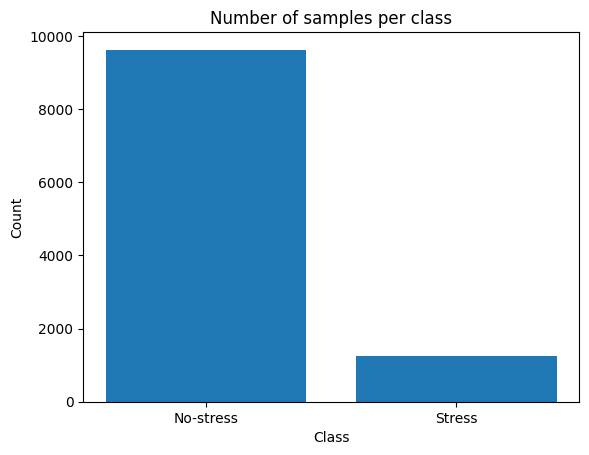

In [18]:
plot_label_distribution(sequences_df)


In [19]:
import pandas as pd
from sklearn.utils import resample

# Separate the majority ('no-stress') and minority ('stress') classes
df_no_stress = sequences_df[sequences_df['downsampled_label'] == 0]
df_stress = sequences_df[sequences_df['downsampled_label'] == 1]

# Downsample the majority class ('no-stress') to match the minority class ('stress')
df_no_stress_downsampled = resample(df_no_stress,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(df_stress),  # Match the number of 'stress' samples
                                    random_state=42)  # Ensure reproducibility

# Combine the downsampled 'no-stress' class with the 'stress' class
sequences_df_balanced = pd.concat([df_no_stress_downsampled, df_stress])

# Shuffle the combined dataset to mix the samples
sequences_df_balanced = sequences_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Label distribution: [1244, 1244]


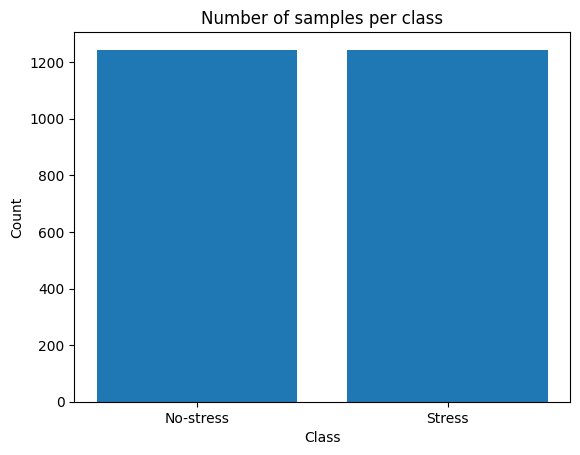

In [20]:
plot_label_distribution(sequences_df_balanced)

****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1.

In [21]:
# Scale the 'w_eda' feature
scaler = preprocessing.MinMaxScaler()
eda_series_list_scaled = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df_balanced[METRIC]]

# Convert the scaled feature back to a list of arrays
eda_array_list = [np.array(series).flatten() for series in eda_series_list_scaled]

# Separate the labels
labels_list = [i for i in sequences_df_balanced['downsampled_label']]

# Convert the labels list to numpy array
labels_array = np.array(labels_list)

# print(len(combined_series_list))
print(f"EDA list Count:", len(eda_series_list_scaled),"\n" "Labels list Count:", len(labels_array))

EDA list Count: 2488 
Labels list Count: 2488


In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Padding sequences to ensure uniform length
max_sequence_length = 32  # Choose the desired maximum sequence length
padded_series_list = pad_sequences(eda_series_list_scaled, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Splitting data into training and testing sets (70% train, 30% test)
x_temp, x_test, y_temp, y_test = train_test_split(
    padded_series_list, labels_list, test_size=0.30, random_state=42, shuffle=True
)

# Further splitting the training data into training and validation sets (80% train, 20% val from the original 70% train)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.20, random_state=42, shuffle=True
)

# Convert to numpy arrays and reshape for compatibility with Keras
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)  # Do not one-hot encode

x_val = np.asarray(x_val).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_val = np.asarray(y_val).astype(np.float32).reshape(-1, 1)  # Do not one-hot encode

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 1 feature (EDA or TEMP)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)  # Do not one-hot encode

# Check lengths of train, validation, and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_val : {len(x_val)}\nLength of x_test : {len(x_test)}\n"
    f"Length of y_train : {len(y_train)}\nLength of y_val : {len(y_val)}\nLength of y_test : {len(y_test)}"
)

Length of x_train : 1392
Length of x_val : 349
Length of x_test : 747
Length of y_train : 1392
Length of y_val : 349
Length of y_test : 747


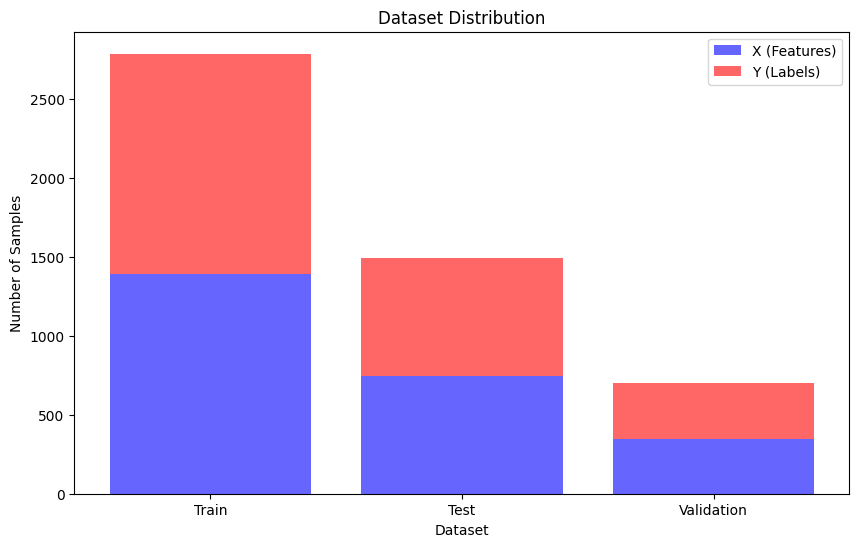

In [23]:
def plot_dataset_distribution(x_train, y_train, x_test, y_test, x_val, y_val):
    """
    Plots a bar chart showing the sizes of the train, validation, and test sets.

    Parameters:
    - x_train, y_train: Training data and labels.
    - x_val, y_val: Validation data and labels.
    - x_test, y_test: Test data and labels.
    """
    dataset_names = ['Train', 'Test', 'Validation']
    x_lengths = [len(x_train), len(x_test), len(x_val)]
    y_lengths = [len(y_train), len(y_test), len(y_val)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    plt.bar(dataset_names, x_lengths, color='b', alpha=0.6, label='X (Features)')
    plt.bar(dataset_names, y_lengths, color='r', alpha=0.6, label='Y (Labels)', bottom=x_lengths)
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.legend()
    plt.savefig("dataset_distribution.png")
    plt.show()


# Plot dataset distribution
plot_dataset_distribution(x_train, y_train, x_test, y_test, x_val, y_val)

In [24]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

def SplitDatasetForFolds(train_index, val_index, fold_nr):
    print(f"Training fold {fold_nr}...")

    # Split the data into train and validation sets for this fold.
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]

    # Create tf.data.Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_fold, y_val_fold))

    # Shuffling and batching the datasets
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)

    return train_dataset, test_dataset, val_dataset

In [25]:
vals_dict = {}
for i in sequences_df_balanced['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)



{0: 0.5, 1: 0.5}


In [26]:
# Assuming your one-hot encoded labels are in a variable named 'labels'
binary_labels = np.argmax(sequences_df['downsampled_label'])
print("Shape of binary labels:", binary_labels.shape)

Shape of binary labels: ()


In [27]:
def plot_history_metrics(history_dict: dict):
    total_plots = len(history_dict)
    cols = total_plots // 2
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history_dict.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [28]:
def create_model():
    input_layer = keras.Input(shape=(32, 1))
    
    x = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    output_layer = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [29]:
conv_model = create_model()
conv_model.summary()

# Save model to JSON
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 32, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,177 (1.63 MB)

 Trainable params: 425,729 (1.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
# To store history of each fold
history_list = []
fold_number = 1

best_val_accuracy = 0
best_model_filename = ""


for train_index, val_index in kfold.split(x_train):
    # Split data into training and validation sets for this fold.
    train_dataset, test_dataset, val_dataset = SplitDatasetForFolds(train_index, val_index, fold_number)

    # Create a new model instance
    model = create_model()

    # Compile the model
    optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
    loss = keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ],
    )

    # Set up callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"best_model_fold_{fold_number}.keras", save_best_only=True, monitor="val_binary_accuracy"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2, patience=15, min_lr=0.000001),
        keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10, restore_best_weights=True),
    ]

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=25,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Append history
    history_list.append(history.history)

        # Check if this model has the best validation accuracy so far
    if history.history['val_binary_accuracy'][-1] > best_val_accuracy:
        best_val_accuracy = history.history['val_binary_accuracy'][-1]
        best_model_filename = f"best_model_fold_{fold_number}.keras"

    fold_number += 1
    print(f"Training fold {fold_number} completed\n")
    print("------------------------------------------------------------------------------------------------------------------\n")

print("Cross-validation training completed")

Training fold 1...
Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc: 0.6403 - binary_accuracy: 0.5929 - loss: 0.8720 - precision: 0.6111 - recall: 0.6227 - val_auc: 0.6093 - val_binary_accuracy: 0.5286 - val_loss: 0.6872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6769 - binary_accuracy: 0.6314 - loss: 0.7504 - precision: 0.6256 - recall: 0.6640 - val_auc: 0.7093 - val_binary_accuracy: 0.5286 - val_loss: 0.6953 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7117 - binary_accuracy: 0.6561 - loss: 0.6613 - precision: 0.6359 - recall: 0.6438 - val_auc: 0.6741 - val_binary_accuracy: 0.5286 - val_loss: 0.6915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.7742 - binary_accuracy: 0.6966 - loss: 0.5866 - precision: 0

In [31]:
# Load the best model
best_model = keras.models.load_model(best_model_filename)

# Now you have the best model, you can evaluate it on the test set
for dataset in [train_dataset, val_dataset]:
    print("Training set" if dataset == train_dataset else "Validation set")
    loss, binary_accuracy, auc, precision, recall = best_model.evaluate(dataset)
    print(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n")

with open(f"metrics.txt", "w") as f:
    f.write(f"Loss: {loss}\n Binary Accuracy: {binary_accuracy}\n AUC: {auc}\n Precision: {precision}\n Recall: {recall}\n") 

Training set
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8814 - binary_accuracy: 0.8097 - loss: 0.4472 - precision: 0.8013 - recall: 0.8465
Loss: 0.42930635809898376
 Binary Accuracy: 0.8938995599746704
 AUC: 0.8212290406227112
 Precision: 0.8005908131599426
 Recall: 0.8589540123939514

Validation set
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9084 - binary_accuracy: 0.8329 - loss: 0.3905 - precision: 0.8115 - recall: 0.8531 
Loss: 0.3765546679496765
 Binary Accuracy: 0.9172877669334412
 AUC: 0.8345323801040649
 Precision: 0.8285714387893677
 Recall: 0.8405796885490417



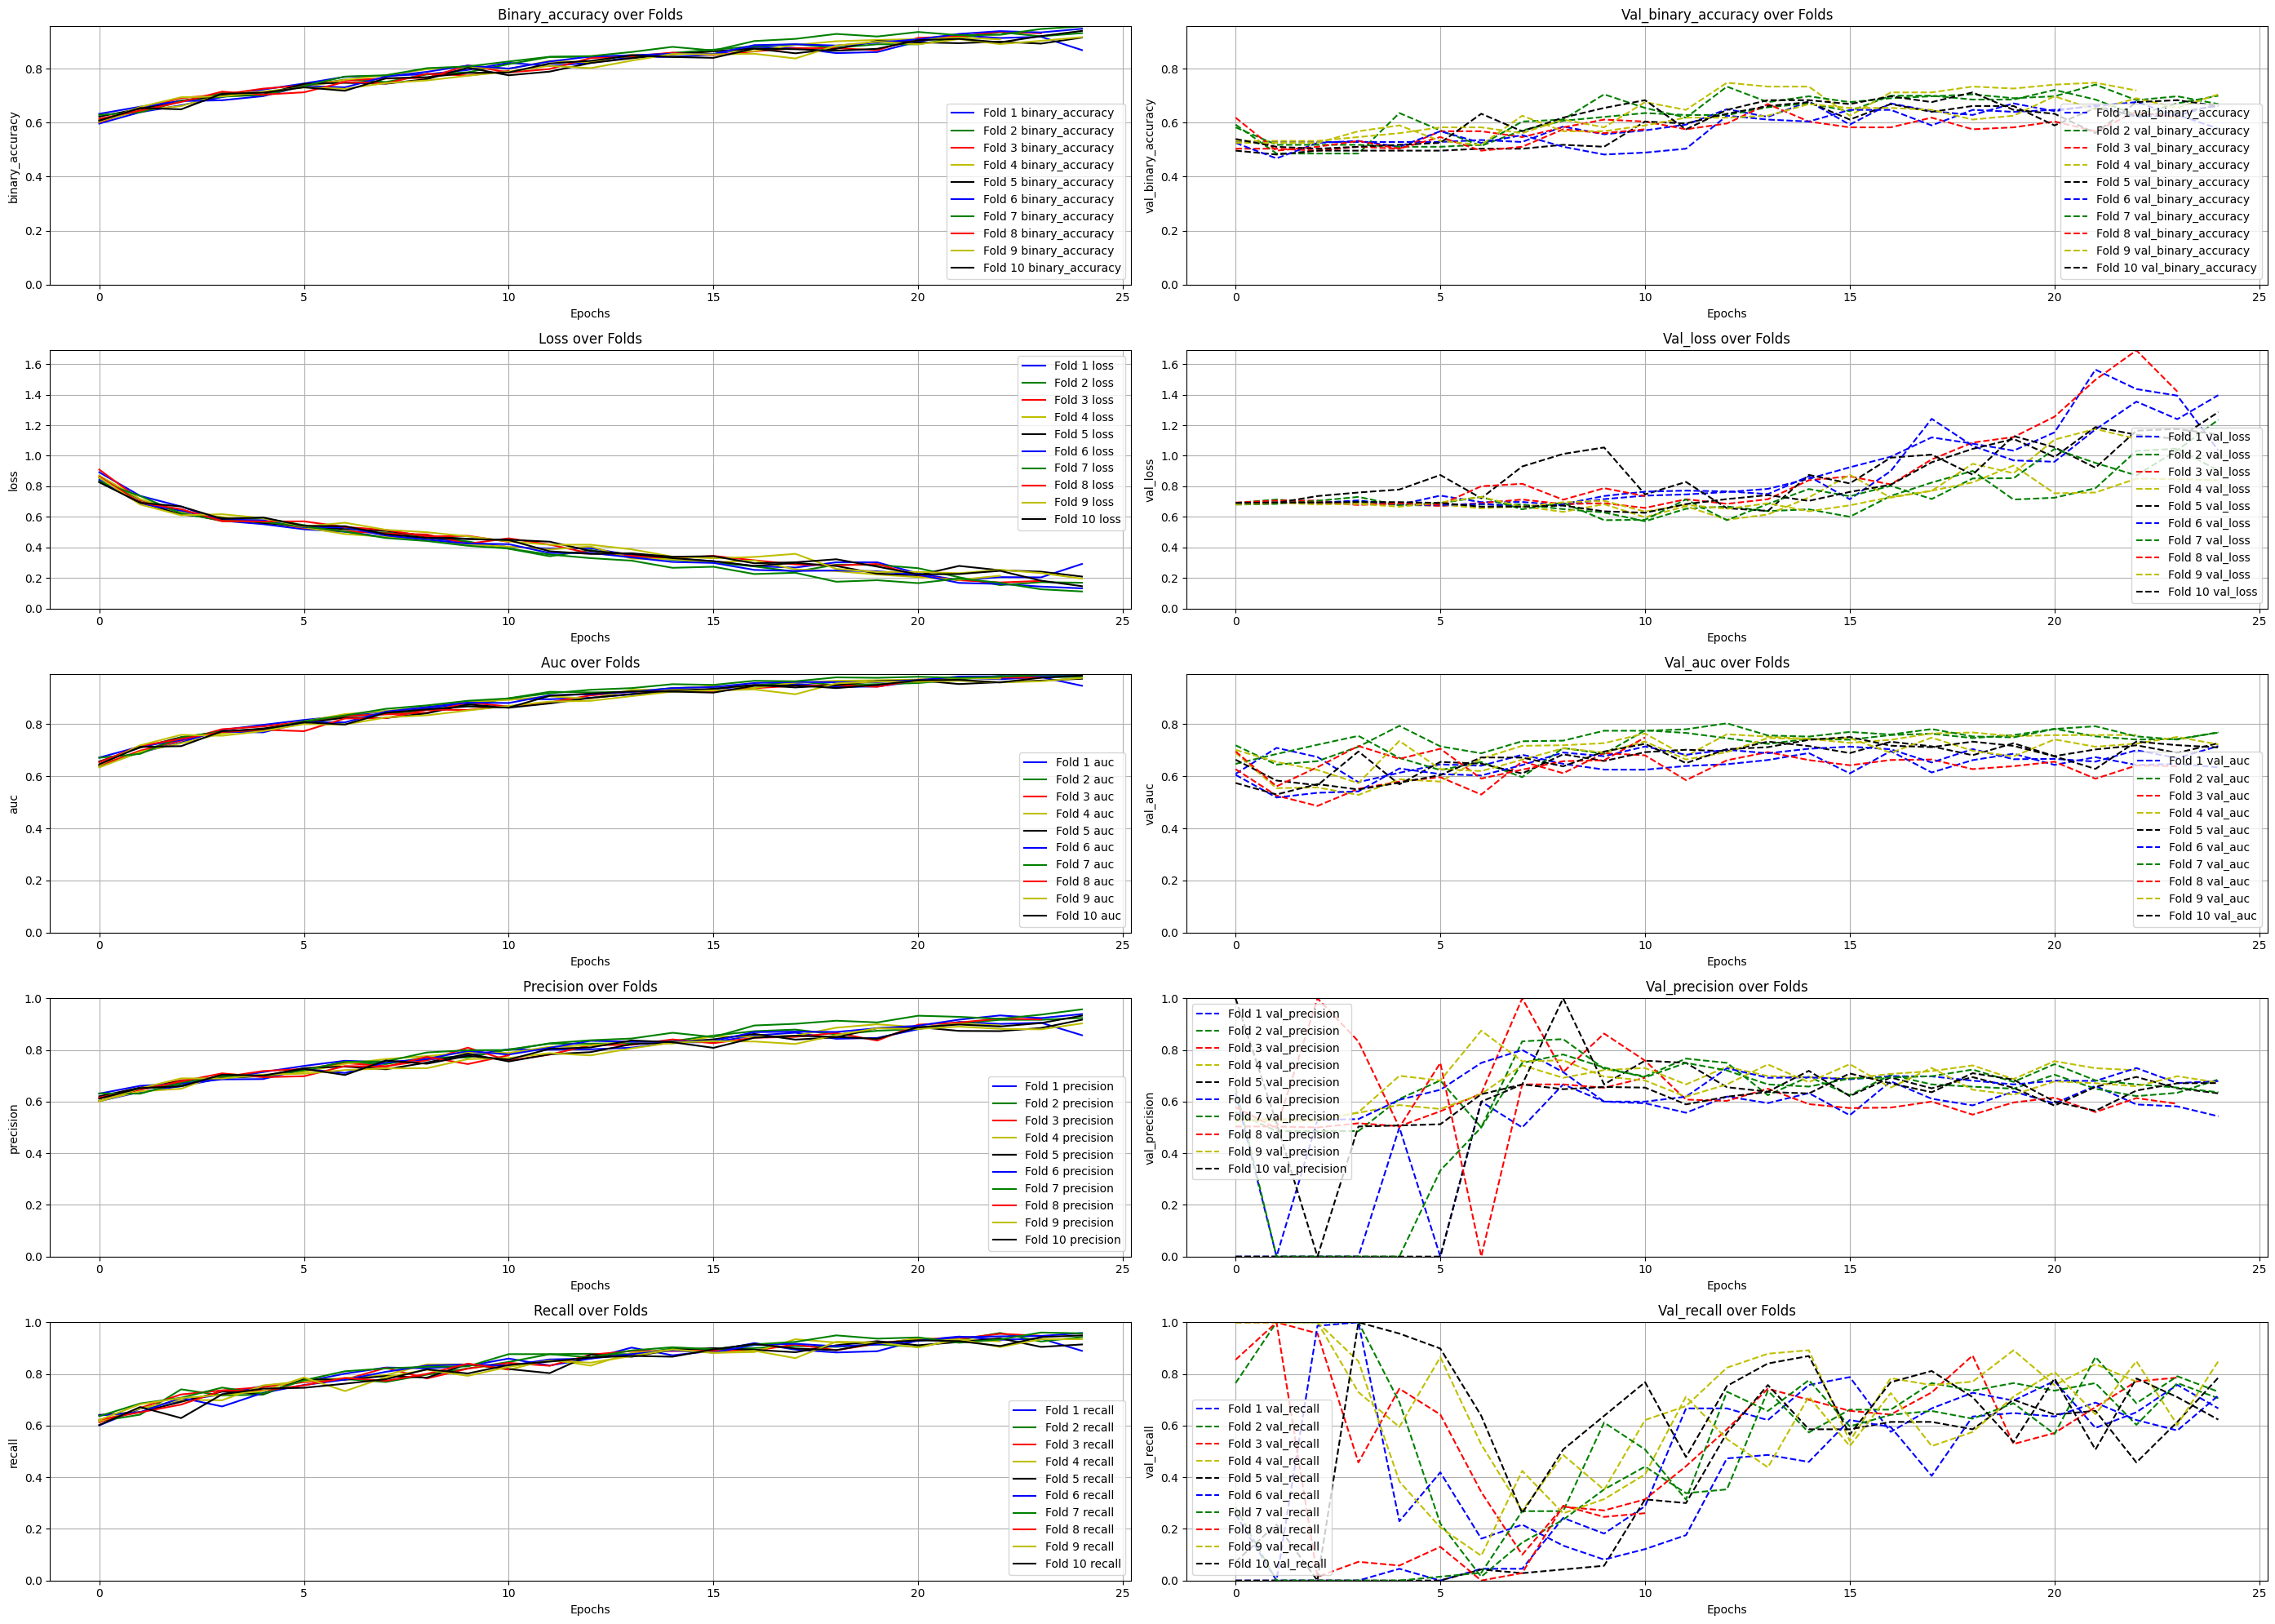

In [32]:
import matplotlib.pyplot as plt

# Define a color scheme for metrics
colors = ['b', 'g', 'r', 'y', 'k']

# Plotting the metrics for all folds
def plot_metrics(history_list, metrics, val_metrics, colors):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(nrows=num_metrics, ncols=2, figsize=(28, 20))
    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        train_max = max([max(history[metric]) for history in history_list])
        val_max = max([max(history[val_metric]) for history in history_list])
        y_max = max(train_max, val_max)
        for j, history in enumerate(history_list):
            color_index = j % len(colors)  # Get color index for this fold
            color = colors[color_index]     # Get color for this fold
            axs[i, 0].plot(history[metric], label=f'Fold {j+1} {metric}', color=color)
            axs[i, 1].plot(history[val_metric], label=f'Fold {j+1} {val_metric}', linestyle='--', color=color)
        axs[i, 0].set_title(f'{metric.capitalize()} over Folds')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel(metric)
        axs[i, 0].legend()
        axs[i, 0].grid()
        axs[i, 0].set_ylim([0, y_max])  # Set y-axis limit for training plot
        
        axs[i, 1].set_title(f'{val_metric.capitalize()} over Folds')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel(val_metric)
        axs[i, 1].legend()
        axs[i, 1].grid()
        axs[i, 1].set_ylim([0, y_max])  # Set y-axis limit for validation plot
        
    plt.tight_layout()
    plt.savefig('folds.png')
    plt.show()

# Updated metrics list based on the actual keys from the history dictionary
metrics = ['binary_accuracy', 'loss', 'auc', 'precision', 'recall']
val_metrics = ['val_binary_accuracy', 'val_loss', 'val_auc', 'val_precision', 'val_recall']

# Plot metrics
plot_metrics(history_list, metrics, val_metrics, colors)


In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

# Generate predictions on the test set
y_pred_probs = best_model.predict(x_train, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute metrics
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_probs)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('model_results.png', dpi = 120)
plt.show()

Confusion Matrix:
[[545 147]
 [100 600]]


ValueError: Found input variables with inconsistent numbers of samples: [349, 1392]

Plotting signals with label 0:


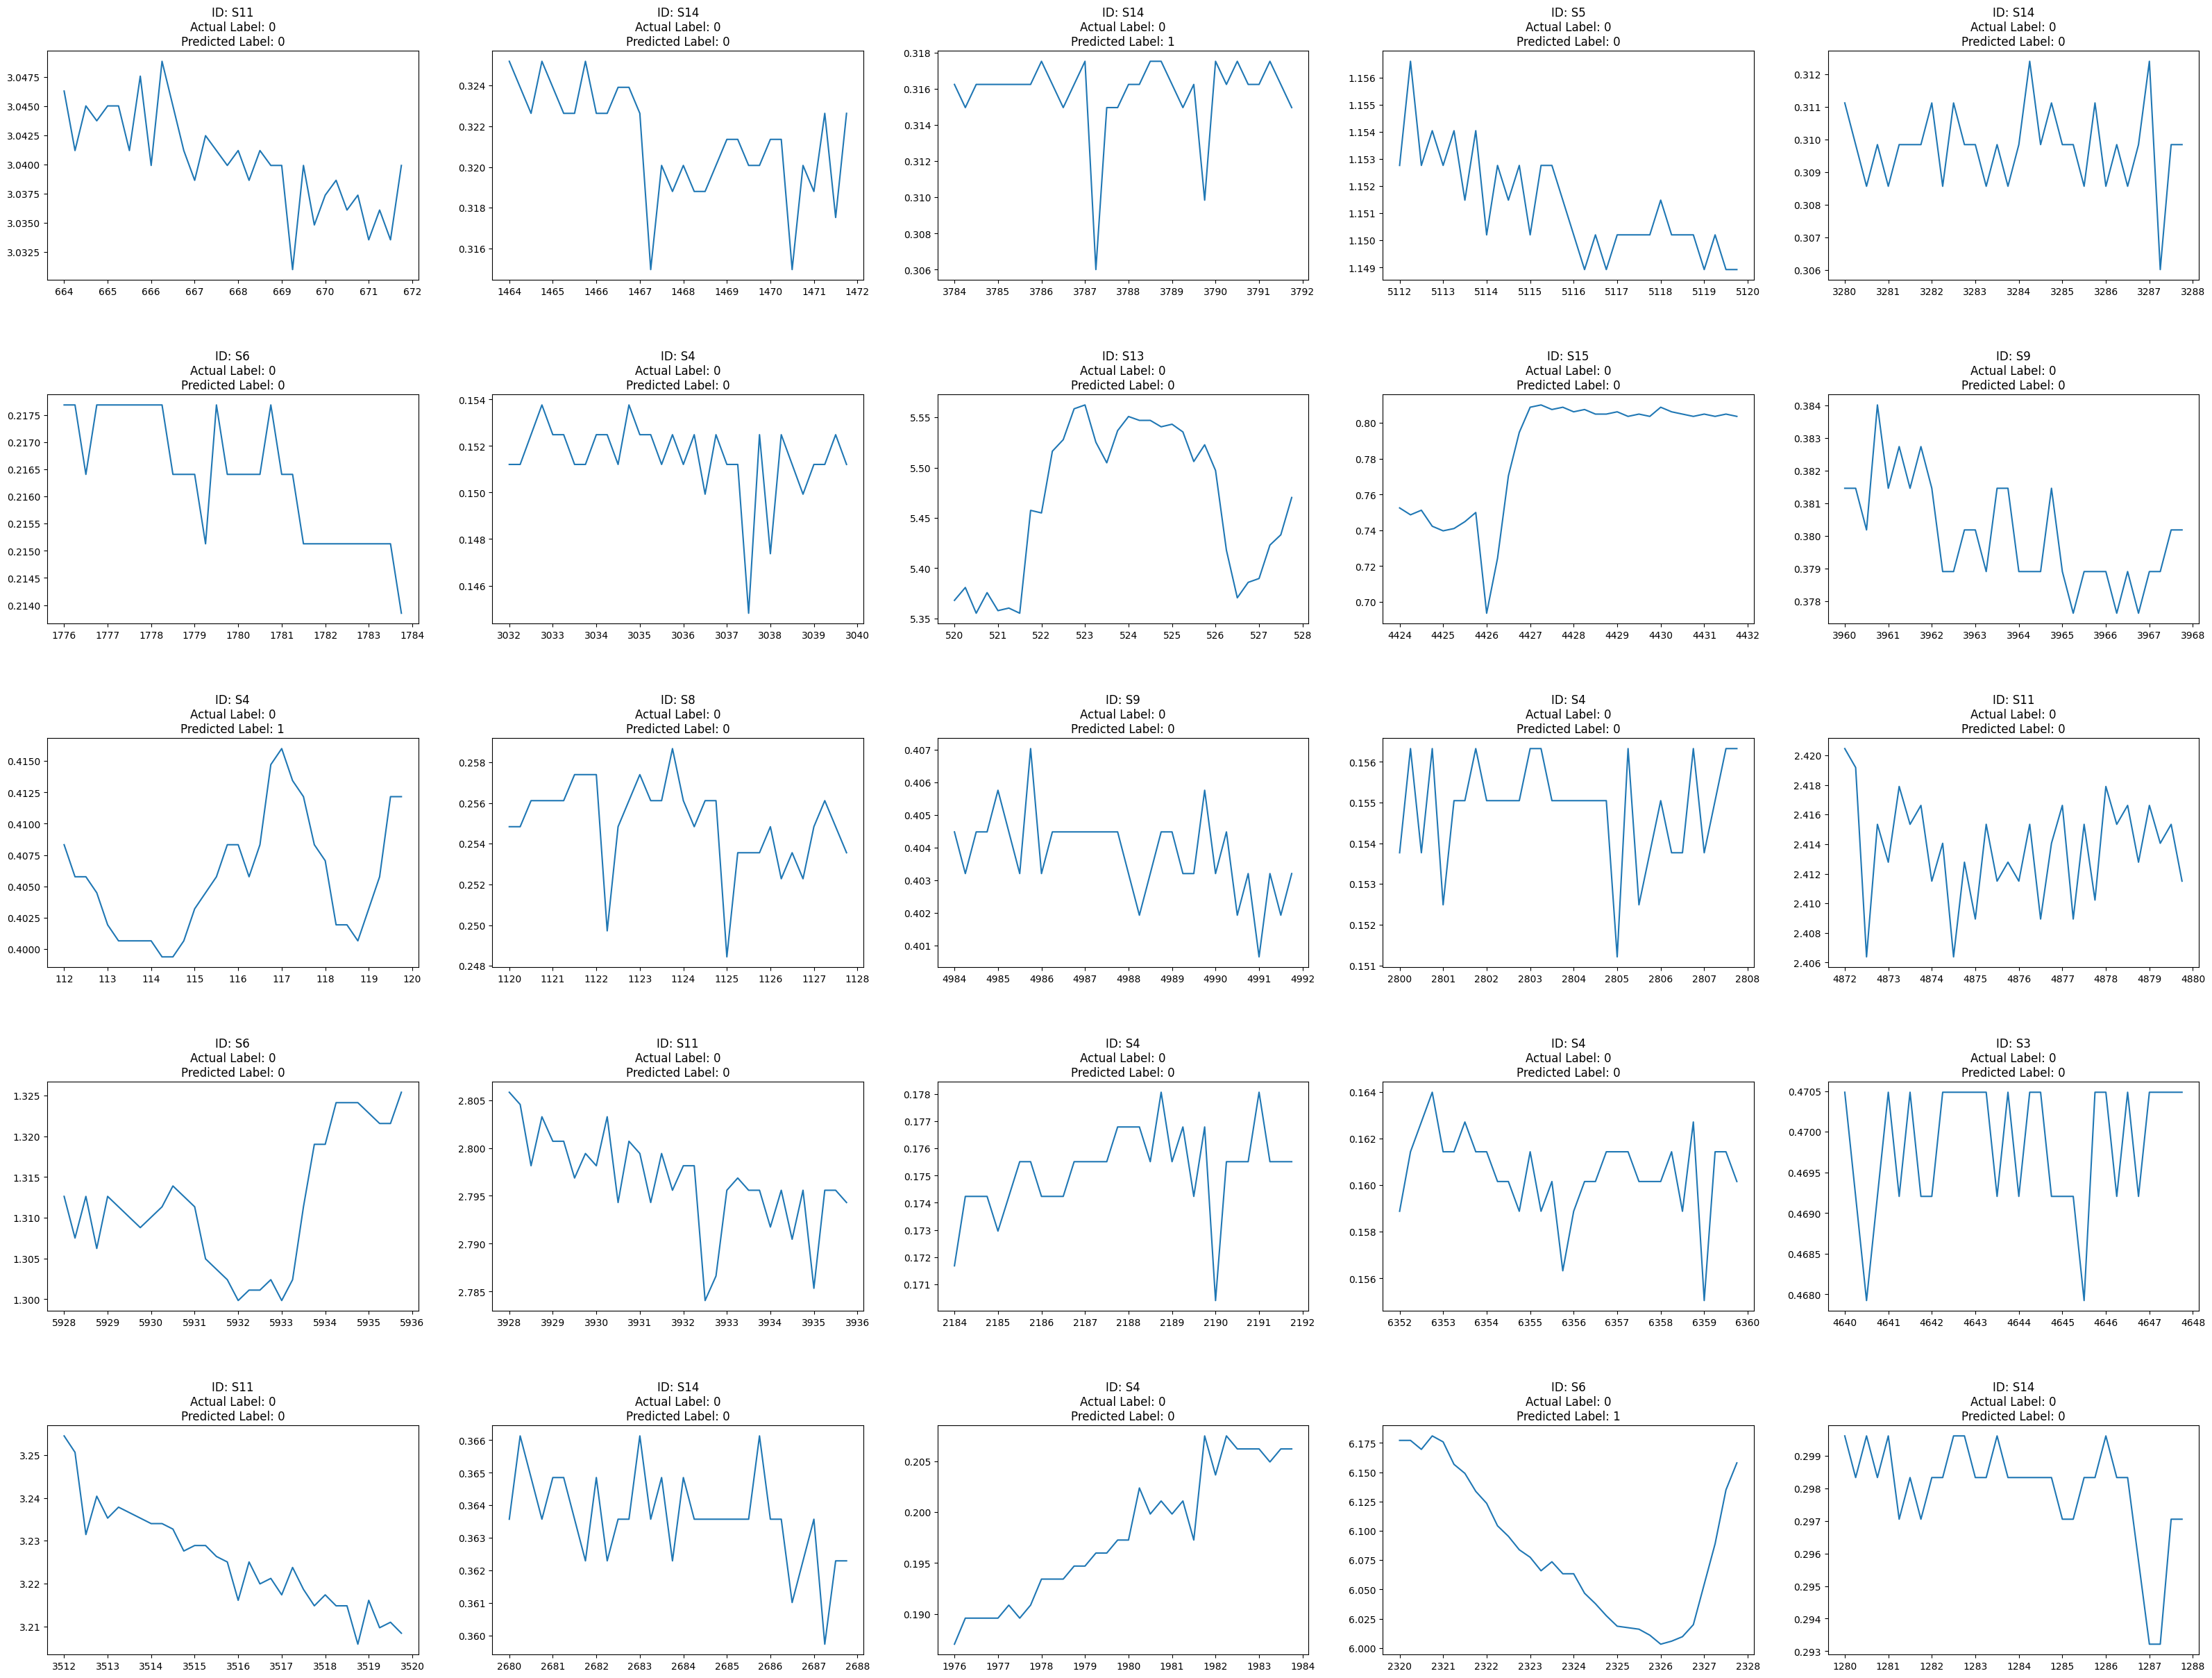

Plotting signals with label 1:


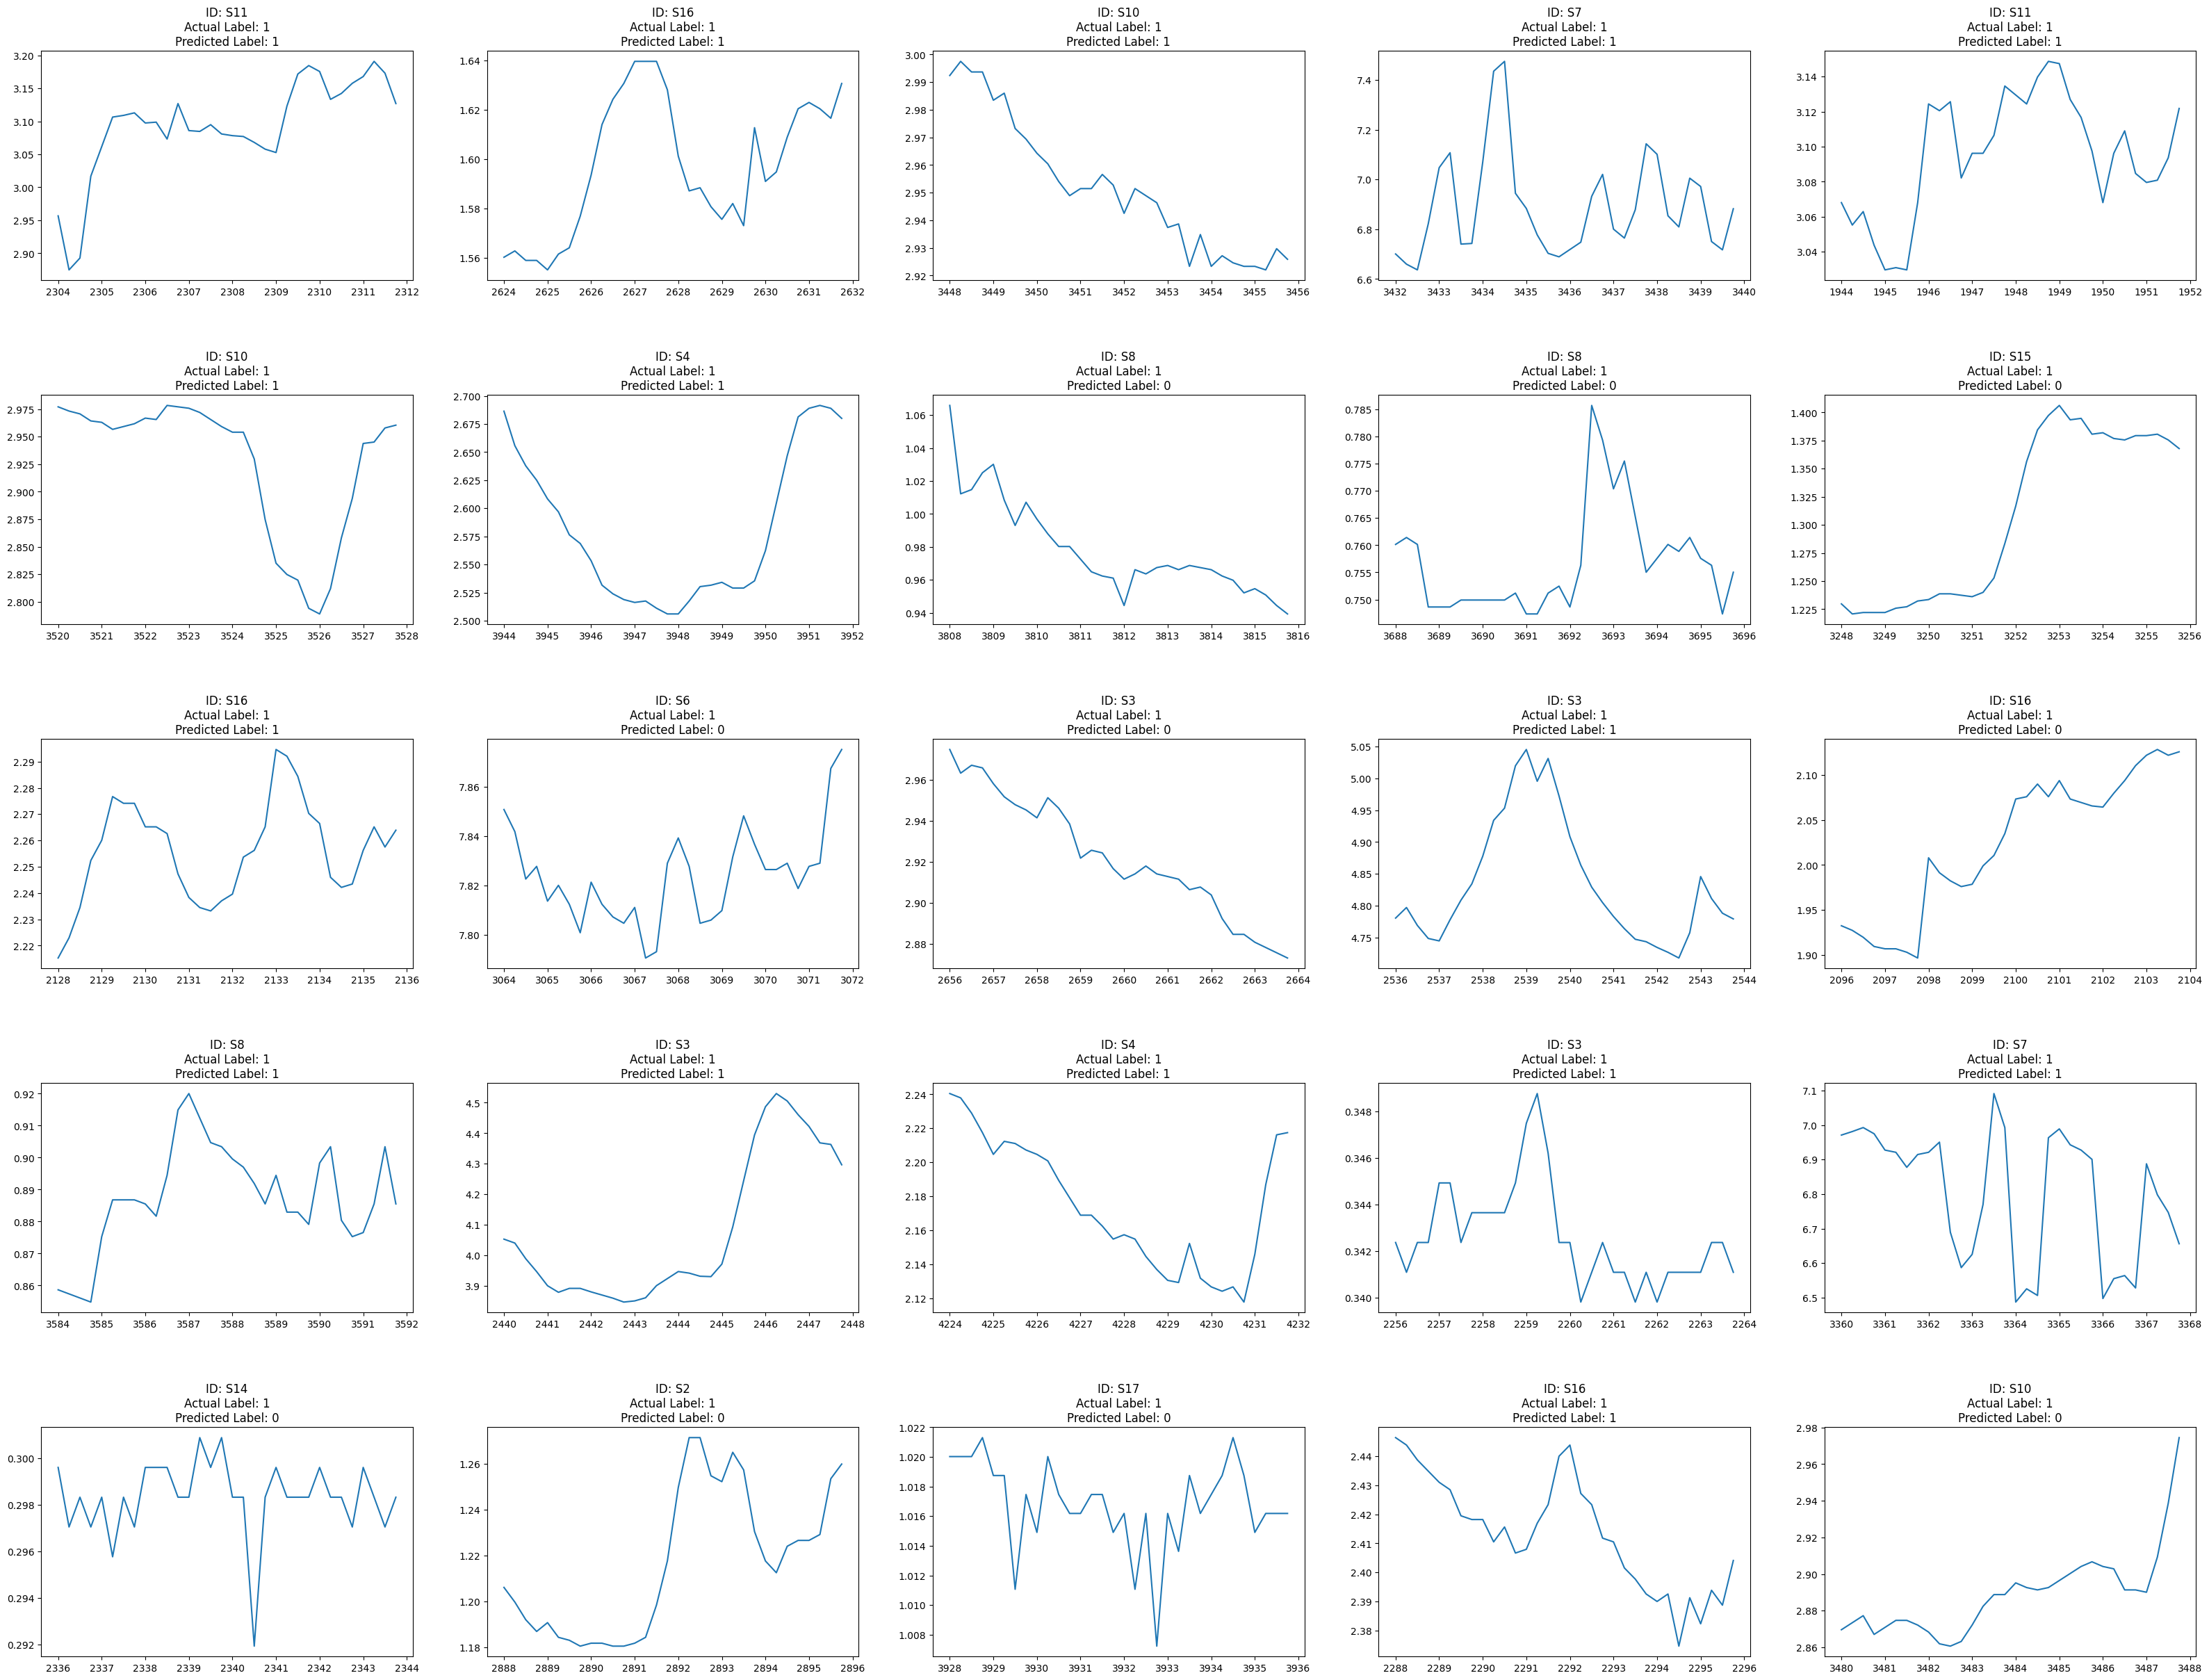

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def view_evaluated_eeg_plots(model, sequences_df, scaler):
    def plot_signals(data, labels, predictions, ids, times):
        total_plots = len(data)
        cols = total_plots // 5
        rows = total_plots // cols
        if total_plots % cols != 0:
            rows += 1
        pos = range(1, total_plots + 1)
        fig = plt.figure(figsize=(40, 30))
        for i, (plot_data, og_label, pred_label, id_, time) in enumerate(zip(data, labels, predictions, ids, times)):
            plt.subplot(rows, cols, pos[i])
            plt.plot(time, plot_data)
            plt.title(f"ID: {id_}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
            fig.subplots_adjust(hspace=0.5)
        plt.show()

    def generate_signals_for_label(label, num_signals=25):
        filtered_df = sequences_df[sequences_df['downsampled_label'] == label]
        sampled_df = filtered_df.sample(n=num_signals, random_state=42)
        data = sampled_df['w_eda']
        times = sampled_df['Time']
        data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
        data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 32, 1)
        labels = sampled_df['downsampled_label'].tolist()
        ids = sampled_df['ID'].tolist()  # Extract IDs
        predictions = (model.predict(data_array, verbose=0) > 0.5).astype(int).flatten()
        return data, labels, predictions, ids, times

    data_0, labels_0, predictions_0, ids_0, times_0 = generate_signals_for_label(0)
    data_1, labels_1, predictions_1, ids_1, times_1 = generate_signals_for_label(1)
    
    print("Plotting signals with label 0:")
    plot_signals(data_0, labels_0, predictions_0, ids_0, times_0)
    
    print("Plotting signals with label 1:")
    plot_signals(data_1, labels_1, predictions_1, ids_1, times_1)

# Call the function with the required arguments
view_evaluated_eeg_plots(best_model, sequences_df, scaler)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def view_evaluated_eeg_plots(model, sequences_df, scaler, target_id):
    def plot_signals(data, labels, predictions, ids, times):
        total_plots = len(data)
        cols = total_plots // 5
        rows = total_plots // cols
        if total_plots % cols != 0:
            rows += 1
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
        for i, (plot_data, og_label, pred_label, id_, time) in enumerate(zip(data, labels, predictions, ids, times)):
            if len(plot_data) == 0:  # Skip empty plots
                continue
            ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
            color = 'green' if og_label == pred_label else 'red'
            ax.plot(time, plot_data, color=color)
            ax.set_title(f"ID: {id_}\nActual Label: {og_label}\nPredicted Label: {pred_label}")
            ax.set_xlabel('Time')
            ax.set_ylabel('Data')
        plt.tight_layout()
        plt.show()

    def generate_signals_for_id(target_id):
        filtered_df = sequences_df[sequences_df['ID'] == target_id]
        filtered_df = filtered_df.sort_values(by='Time')  # Sort by time
        data = filtered_df['w_eda']
        times = filtered_df['Time']
        data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
        data_array = np.asarray(data_array).astype(np.float32).reshape(-1, 32, 1)
        labels = filtered_df['downsampled_label'].tolist()
        ids = filtered_df['ID'].tolist()  # Extract IDs
        predictions = (model.predict(data_array, verbose=0) > 0.5).astype(int).flatten()
        return data, labels, predictions, ids, times

    data, labels, predictions, ids, times = generate_signals_for_id(target_id)
    
    print(f"Plotting signals for ID: {target_id}")
    plot_signals(data, labels, predictions, ids, times)

    # Create confusion matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with the required arguments
view_evaluated_eeg_plots(best_model, sequences_df_balanced, scaler, target_id='S2')


NameError: name 'sequences_df_balanced' is not defined